# Airbnb NYC Data Pre-processing & ETL

This notebook implements the end-to-end data pipeline to create the final modeling dataset from raw InsideAirbnb snapshots.

**Objective:** Load all monthly listings snapshots and the full reviews history, clean features, engineer the `estimated_occupancy_rate` sample weight, and produce a single, model-ready `listing-month` panel.

### 0. Setup & Data Loading

In [38]:
import pandas as pd
import numpy as np
import os
import glob

# --- Configuration ---
# Parent directory containing the 'listings-YY-MM.csv' files and '{CITY}-reviews-detailed...csv'
CITY = "la"
INPUT_DATA_DIR = os.path.expanduser(f"~/Downloads/insideairbnb/{CITY}") 
OUTPUT_DATA_DIR = os.path.expanduser(f"../data/{CITY}")
OUTPUT_FILENAME = f"{CITY}_dataset_oct_20.parquet"

# Configure pandas display
pd.options.display.max_columns = 100

# --- Load All Monthly Listings Snapshots ---
listings_files = sorted(glob.glob(os.path.join(INPUT_DATA_DIR, 'listings-*.csv')))
if not listings_files:
    raise FileNotFoundError(f"No 'listings-*.csv' files found in {INPUT_DATA_DIR}")

print(f"Found {len(listings_files)} monthly listings files. Loading and concatenating...")

dfs = []
for file in listings_files:
    # low_memory=False handles mixed data types in raw CSVs
    df = pd.read_csv(file, low_memory=False) 
    dfs.append(df)

raw_listings_df = pd.concat(dfs, ignore_index=True)
print(f"Successfully loaded {len(raw_listings_df):,} total listing records.")

# --- Load Full Reviews History ---
reviews_path = os.path.join(INPUT_DATA_DIR, f'{CITY}-reviews-detailed-insideairbnb.csv')
print(f"Loading reviews from: {os.path.basename(reviews_path)}...")
try:
    raw_reviews_df = pd.read_csv(reviews_path)
    print(f"Successfully loaded {len(raw_reviews_df):,} reviews.")
except FileNotFoundError:
    raise FileNotFoundError(f"Could not find reviews file at: {reviews_path}")

# Display samples
print("\nListings Sample:")
display(raw_listings_df.head(2))
print("\nReviews Sample:")
display(raw_reviews_df.head(2))

# Display column info
print("\nListings DataFrame Info:")
print(raw_listings_df.info())
print("\nReviews DataFrame Info:")
print(raw_reviews_df.info())

Found 4 monthly listings files. Loading and concatenating...
Successfully loaded 182,959 total listing records.
Loading reviews from: la-reviews-detailed-insideairbnb.csv...
Successfully loaded 1,747,347 reviews.

Listings Sample:


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d
0,109,https://www.airbnb.com/rooms/109,20241206031821,2024-12-06,city scrape,Amazing bright elegant condo park front *UPGRA...,"*** Unit upgraded with new bamboo flooring, ne...",NaN,https://a0.muscache.com/pictures/miso/Hosting-...,521,https://www.airbnb.com/users/show/521,Paolo,2008-06-27,"San Francisco, CA","Husband, father, MIT MBA, Silicon Valley-based...",NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/User-...,https://a0.muscache.com/im/pictures/user/User-...,Culver City,1.0,3.0,"['email', 'phone']",t,t,NaN,Culver City,Other Cities,33.98301,-118.38607,Entire condo,Entire home/apt,6,2.0,2 baths,2.0,2.0,"[""Free parking on premises"", ""Hangers"", ""Gym"",...",$129.00,30,730,30.0,30.0,730.0,730.0,30.0,730.0,NaN,t,0,0,0,174,2024-12-06,2,0,0,2011-08-15,2016-05-15,4.00,5.00,5.00,3.0,4.00,5.00,4.00,NaN,f,1,1,0,0,0.01,NaN,NaN,NaN,NaN
1,2708,https://www.airbnb.com/rooms/2708,20241206031821,2024-12-07,city scrape,Runyon Canyon | Beau Furn Mirror Mini-Suite Fi...,"Run Runyon Canyon, Our Gym & Sauna Open <br />...","Walk and run to Runyon Canyon, it is open!<br ...",https://a0.muscache.com/pictures/40618141/2ac0...,3008,https://www.airbnb.com/users/show/3008,Chas.,2008-09-16,"Los Angeles, CA",Professional and technical writer.\nLiterary C...,within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/d17cf...,https://a0.muscache.com/im/pictures/user/d17cf...,Hollywood,2.0,3.0,"['email', 'phone']",t,t,Neighborhood highlights,Hollywood,City of Los Angeles,34.09741,-118.34494,Private room in rental unit,Private room,1,1.0,1 shared bath,1.0,1.0,"[""Free parking on premises"", ""Samsung refriger...",$87.00,30,550,30.0,30.0,1125.0,1125.0,30.0,1125.0,NaN,t,30,60,90,365,2024-12-07,44,4,1,2014-06-09,2024-12-01,4.86,4.82,4.93,5.0,4.98,4.95,4.86,NaN,t,2,0,2,0,0.34,NaN,NaN,NaN,NaN



Reviews Sample:


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2708,13994902,2014-06-09,10905424,Kuberan,i had a wonderful stay. Everything from start ...
1,2708,14606598,2014-06-23,2247288,Camilla,Charles is just amazing and he made my stay sp...



Listings DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182959 entries, 0 to 182958
Data columns (total 79 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   id                                            182959 non-null  int64  
 1   listing_url                                   182959 non-null  object 
 2   scrape_id                                     182959 non-null  int64  
 3   last_scraped                                  182959 non-null  object 
 4   source                                        182959 non-null  object 
 5   name                                          182955 non-null  object 
 6   description                                   178799 non-null  object 
 7   neighborhood_overview                         84205 non-null   object 
 8   picture_url                                   182959 non-null  object 
 9   host_id               

### 1. Remove unnecessary columns

In [39]:
cols_to_keep = [
    'id',
    'host_id',
    'name',
    'description',
    'host_is_superhost',
    'neighbourhood_cleansed',
    'latitude',
    'longitude',
    'property_type',
    'room_type',
    'accommodates',
    'bathrooms',
    'bedrooms',
    'beds',
    'amenities',
    'minimum_nights',
    'review_scores_rating',  #float
    'review_scores_accuracy',  #float
    'review_scores_cleanliness',  #float
    'review_scores_checkin',  #float
    'review_scores_communication',  #float
    'review_scores_location',  #float
    'review_scores_value',  #float
    'last_scraped',
    'price'
    ]

listings_df = raw_listings_df[cols_to_keep].copy()
print(f"\nReduced listings DataFrame to {len(listings_df.columns)} columns.")
print(listings_df.info())


Reduced listings DataFrame to 25 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182959 entries, 0 to 182958
Data columns (total 25 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           182959 non-null  int64  
 1   host_id                      182959 non-null  int64  
 2   name                         182955 non-null  object 
 3   description                  178799 non-null  object 
 4   host_is_superhost            176468 non-null  object 
 5   neighbourhood_cleansed       182959 non-null  object 
 6   latitude                     182959 non-null  float64
 7   longitude                    182959 non-null  float64
 8   property_type                182959 non-null  object 
 9   room_type                    182959 non-null  object 
 10  accommodates                 182959 non-null  int64  
 11  bathrooms                    147750 non-null  float64
 12  bedrooms       

### 2. Convert the scrape-date to month (1-12), convert `host_is_superhost` col to numeric 0/1

In [40]:
# Convert last_scraped to datetime
raw_listings_df['last_scraped'] = pd.to_datetime(raw_listings_df['last_scraped'], errors='coerce')

# Convert last_scraped to month only (no year)
listings_df['month'] = raw_listings_df['last_scraped'].dt.month

# Drop the last_scraped column as it's no longer needed
listings_df = listings_df.drop(columns=['last_scraped'])

### 3. Clean price column, drop outliers, add price-per-person and log1p of both

In [41]:
# Convert prices to float
listings_df['price'] = listings_df['price'].replace(r'[\$,]', '', regex=True).astype(float)

# Drop NaN's from price column and make it float
listings_df = listings_df.dropna(subset=['price'])

# Add price_per_person column
listings_df['price_per_person'] = listings_df['price'] / listings_df['accommodates']

# Drop the bottom 5% and top 5% of price_per_person to remove outliers
lower_bound = listings_df['price_per_person'].quantile(0.05)
upper_bound = listings_df['price_per_person'].quantile(0.95)
listings_df = listings_df[(listings_df['price_per_person'] >= lower_bound) & (listings_df['price_per_person'] <= upper_bound)]

# Add log1p transformed columns
listings_df['log_price'] = np.log1p(listings_df['price'])
listings_df['log_price_per_person'] = np.log1p(listings_df['price_per_person'])

# Print info and a sample
print("\nUpdated Listings DataFrame Info:")
print(listings_df.info())
print("\nListings DataFrame Sample with New Columns:")
display(listings_df.head(5))


Updated Listings DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 133070 entries, 0 to 182958
Data columns (total 28 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           133070 non-null  int64  
 1   host_id                      133070 non-null  int64  
 2   name                         133070 non-null  object 
 3   description                  130947 non-null  object 
 4   host_is_superhost            127727 non-null  object 
 5   neighbourhood_cleansed       133070 non-null  object 
 6   latitude                     133070 non-null  float64
 7   longitude                    133070 non-null  float64
 8   property_type                133070 non-null  object 
 9   room_type                    133070 non-null  object 
 10  accommodates                 133070 non-null  int64  
 11  bathrooms                    133015 non-null  float64
 12  bedrooms                     

,id,host_id,name,description,host_is_superhost,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,minimum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,month,price_per_person,log_price,log_price_per_person
0,109,521,Amazing bright elegant condo park front *UPGRA...,"*** Unit upgraded with new bamboo flooring, ne...",f,Culver City,33.98301,-118.38607,Entire condo,Entire home/apt,6,2.0,2.0,2.0,"[""Free parking on premises"", ""Hangers"", ""Gym"",...",30,4.00,5.00,5.00,3.00,4.00,5.00,4.00,129.0,12,21.500000,4.867534,3.113515
1,2708,3008,Runyon Canyon | Beau Furn Mirror Mini-Suite Fi...,"Run Runyon Canyon, Our Gym & Sauna Open <br />...",t,Hollywood,34.09741,-118.34494,Private room in rental unit,Private room,1,1.0,1.0,1.0,"[""Free parking on premises"", ""Samsung refriger...",30,4.86,4.82,4.93,5.00,4.98,4.95,4.86,87.0,12,87.000000,4.477337,4.477337
2,2732,3041,Zen Life at the Beach,An oasis of tranquility awaits you.,f,Santa Monica,34.00467,-118.48050,Private room in rental unit,Private room,1,1.0,1.0,1.0,"[""Host greets you"", ""Hangers"", ""Free street pa...",7,4.41,4.26,4.58,4.39,4.48,4.91,4.22,139.0,12,139.000000,4.941642,4.941642
5,6931,3008,"RUN Runyon, Beau Furn Rms w/ Stunning Terrace ...",Run Runyon Canyon and Views<br /><br />Gym & S...,t,Hollywood,34.09583,-118.34928,Private room in rental unit,Private room,1,1.0,1.0,1.0,"[""Clothing storage"", ""Free parking on premises...",30,4.84,4.84,4.90,4.90,4.90,4.68,4.74,92.0,12,92.000000,4.532599,4.532599
6,7992,22363,Quiet/Cozy/Clean/Walkable Quaint Area,"Hello, Traveler. Please inquire about dates be...",t,Atwater Village,34.11458,-118.26109,Entire guesthouse,Entire home/apt,3,1.0,1.0,2.0,"[""Single level home"", ""Dining table"", ""Laundro...",31,4.95,4.95,4.93,4.98,4.98,4.93,4.89,100.0,12,33.333333,4.615121,3.536117


In [42]:
listings_df['month'].value_counts()

month
12    34365
9     33224
6     33159
3     32322
Name: count, dtype: int64

### 4. Keep only listings with at least one review, drop rows with NaN's, keep only listings that appear in at least 8 months (unless the data is quarterly)

In [43]:
# Compare IDs between listings_df and raw_reviews_df
listings_ids = set(listings_df['id'].unique())
reviews_ids = set(raw_reviews_df['listing_id'].unique())

common_ids = listings_ids & reviews_ids
only_in_listings = listings_ids - reviews_ids
only_in_reviews = reviews_ids - listings_ids

print(f"Total unique IDs in listings: {len(listings_ids)}")
print(f"Total unique IDs in reviews: {len(reviews_ids)}")
print(f"Common IDs: {len(common_ids)}")
print(f"IDs only in listings: {len(only_in_listings)}")
print(f"IDs only in reviews: {len(only_in_reviews)}")

# Optionally, display some samples
print("\nSample common IDs:", list(common_ids)[:5])
print("Sample only in listings:", list(only_in_listings)[:5])
print("Sample only in reviews:", list(only_in_reviews)[:5])

# Keep only common IDs in listings and reviews
common_listings_df = listings_df[listings_df['id'].isin(common_ids)]
common_reviews_df = raw_reviews_df[raw_reviews_df['listing_id'].isin(common_ids)]

# Drop all listings with NaN's
common_listings_df = common_listings_df.dropna()

# Keep only listings that appear at least 8 times (unless data is quarterly)
if listings_df['month'].nunique() > 4:
    common_listings_df = common_listings_df[common_listings_df.groupby('id')['id'].transform('size') >= 8]

# Display info after filtering
print("\nFiltered Listings DataFrame Info:")
print(common_listings_df.info())
print("\nFiltered Reviews DataFrame Info:")
print(common_reviews_df.info())

Total unique IDs in listings: 51104
Total unique IDs in reviews: 33385
Common IDs: 28175
IDs only in listings: 22929
IDs only in reviews: 5210

Sample common IDs: [np.int64(25034755), np.int64(52428810), np.int64(25034768), np.int64(747219174767329298), np.int64(948068916429586471)]
Sample only in listings: [np.int64(1495046942700601351), np.int64(13762581), np.int64(1379773999302180888), np.int64(555145243064664092), np.int64(37748770)]
Sample only in reviews: [np.int64(36732930), np.int64(51085314), np.int64(25296905), np.int64(28180503), np.int64(34144281)]

Filtered Listings DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 82028 entries, 1 to 182938
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           82028 non-null  int64  
 1   host_id                      82028 non-null  int64  
 2   name                         82028 non-null  object 
 3 

### 5. Add column with total reviews extracted from `common_reviews_df`, format `host_is_superhost`, `bedrooms`, and `beds` columns 

In [44]:
# Aggregate reviews to get total reviews per listing
reviews_count = common_reviews_df.groupby('listing_id').size().reset_index(name='total_reviews')

# Merge on the listing ID
final_df = common_listings_df.merge(reviews_count, left_on='id', right_on='listing_id', how='left')

# Convert total_reviews to int
final_df['total_reviews'] = final_df['total_reviews'].astype('int')

# Drop the redundant listing_id column
final_df = final_df.drop(columns=['listing_id'])

# Convert host_is_superhost to numeric 0/1
final_df['host_is_superhost'] = final_df['host_is_superhost'].astype(str).map({'t': 1, 'f': 0})

# Convert bedrooms and beds to int
final_df['bedrooms'] = final_df['bedrooms'].astype('int')
final_df['beds'] = final_df['beds'].astype('int')

# Print information about the final DataFrame
print(f"\nFinal listings dataset for {CITY}:")
display(final_df.info())

# Display 3 sample listings (all occurrences)
sample_ids = np.random.choice(final_df['id'].unique(), size=3, replace=False)
for listing_id in sample_ids:
    listing_reviews = final_df[final_df['id'] == listing_id]
    print(f"\nSample data for listing ID {listing_id}:")
    display(listing_reviews)


Final listings dataset for la:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82028 entries, 0 to 82027
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           82028 non-null  int64  
 1   host_id                      82028 non-null  int64  
 2   name                         82028 non-null  object 
 3   description                  82028 non-null  object 
 4   host_is_superhost            82028 non-null  int64  
 5   neighbourhood_cleansed       82028 non-null  object 
 6   latitude                     82028 non-null  float64
 7   longitude                    82028 non-null  float64
 8   property_type                82028 non-null  object 
 9   room_type                    82028 non-null  object 
 10  accommodates                 82028 non-null  int64  
 11  bathrooms                    82028 non-null  float64
 12  bedrooms                     82028 non-nul

None


Sample data for listing ID 915167937499720124:


,id,host_id,name,description,host_is_superhost,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,minimum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,month,price_per_person,log_price,log_price_per_person,total_reviews
13264,915167937499720124,513819576,Private Queen/Private Bath in 3 Bdrm/2 Bath home!,"Home in Culver City! Excellent location, free ...",1,Culver City,33.988626,-118.40339,Private room in home,Private room,2,1.0,1,1,"[""Free parking on premises"", ""Single level hom...",2,4.95,4.95,4.84,4.87,4.92,4.87,4.89,110.0,12,55.0,4.709530,4.025352,57
31075,915167937499720124,513819576,Private Queen/Private Bath in 3 Bdrm/2 Bath home!,"Home in Culver City! Excellent location, free ...",1,Culver City,33.988626,-118.40339,Private room in home,Private room,2,1.0,1,1,"[""Microwave"", ""Fire extinguisher"", ""Hot water""...",2,4.95,4.95,4.86,4.88,4.93,4.88,4.90,106.0,3,53.0,4.672829,3.988984,57
50341,915167937499720124,513819576,Private Queen/Private Bath in 3 Bdrm/2 Bath home!,"Home in Culver City! Excellent location, free ...",1,Culver City,33.988626,-118.40339,Private room in home,Private room,2,1.0,1,1,"[""Stove"", ""Extra pillows and blankets"", ""Coffe...",2,4.96,4.96,4.84,4.90,4.94,4.90,4.92,95.0,6,47.5,4.564348,3.881564,57
72068,915167937499720124,513819576,Private Queen/Private Bath in 3 Bdrm/2 Bath home!,"Home in Culver City! Excellent location, free ...",1,Culver City,33.988626,-118.40339,Private room in home,Private room,2,1.0,1,1,"[""Coffee"", ""Dishes and silverware"", ""Iron"", ""S...",2,4.93,4.96,4.81,4.91,4.95,4.89,4.89,110.0,9,55.0,4.709530,4.025352,57



Sample data for listing ID 1113172681518834910:


,id,host_id,name,description,host_is_superhost,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,minimum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,month,price_per_person,log_price,log_price_per_person,total_reviews
15773,1113172681518834910,449460327,Cozy and Stylish Unit,ATTENTION THIS IS NOT BEVERLY HILLS. THIS IS m...,0,Beverly Hills,34.077462,-118.392117,Entire rental unit,Entire home/apt,3,1.0,1,1,"[""Free parking on premises"", ""Keypad"", ""Gym in...",1,4.88,4.88,4.88,4.88,5.0,4.75,4.75,105.0,12,35.000000,4.663439,3.583519,11
33607,1113172681518834910,449460327,Cozy and Stylish Unit,ATTENTION THIS IS NOT BEVERLY HILLS. THIS IS m...,0,Beverly Hills,34.077462,-118.392117,Entire rental unit,Entire home/apt,3,1.0,1,1,"[""Microwave"", ""Bed linens"", ""Shampoo"", ""Essent...",1,4.88,4.88,4.88,4.88,5.0,4.75,4.75,116.0,3,38.666667,4.762174,3.680511,11
52871,1113172681518834910,449460327,Cozy and Stylish Unit,ATTENTION THIS IS NOT BEVERLY HILLS. THIS IS m...,0,Beverly Hills,34.077462,-118.392117,Entire rental unit,Entire home/apt,3,1.0,1,1,"[""Stove"", ""Extra pillows and blankets"", ""Gym i...",1,4.88,4.88,4.88,4.88,5.0,4.75,4.75,165.0,6,55.000000,5.111988,4.025352,11



Sample data for listing ID 17545577:


,id,host_id,name,description,host_is_superhost,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,minimum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,month,price_per_person,log_price,log_price_per_person,total_reviews
2630,17545577,10156476,ZEN STUDIO - 6 blocks from BEACH!,REDUCED - Our small Studio is part of the mode...,1,Santa Monica,34.00351,-118.478,Entire guest suite,Entire home/apt,2,1.0,1,1,"[""Hangers"", ""Essentials"", ""Heating"", ""First ai...",4,5.0,4.93,4.95,4.93,4.98,5.0,4.87,210.0,12,105.0,5.351858,4.663439,49
20667,17545577,10156476,ZEN STUDIO - 6 blocks from BEACH!,REDUCED - Our small Studio is part of the mode...,1,Santa Monica,34.00351,-118.478,Entire guest suite,Entire home/apt,2,1.0,1,1,"[""Fire extinguisher"", ""Hot water"", ""Bed linens...",3,5.0,4.93,4.95,4.93,4.98,5.0,4.87,220.0,3,110.0,5.398163,4.709530,49
61008,17545577,10156476,ZEN STUDIO - 6 blocks from BEACH!,REDUCED - Our small Studio is part of the mode...,1,Santa Monica,34.00351,-118.478,Entire rental unit,Entire home/apt,2,1.0,0,1,"[""Self check-in"", ""Resort access"", ""Dryer"", ""L...",4,5.0,4.94,4.96,4.92,4.98,5.0,4.87,200.0,9,100.0,5.303305,4.615121,49


### 6. Clean up amenities

In [45]:
import ast
import re

# --- 1. Helper functions ---
def clean_and_format_amenities(amenities_str: str) -> str:
    """
    Safely parses a stringified list of amenities and returns
    a single, comma-separated string suitable for a sentence transformer.

    Args:
        amenities_str: The raw string from the 'amenities' column.

    Returns:
        A clean, comma-separated string of amenities, or an empty string
        if the input is invalid or empty.
    """
    if not isinstance(amenities_str, str) or amenities_str in ('', '[]'):
        return ""
    
    try:
        # ast.literal_eval is the safest way to parse a string
        # that should contain a Python literal (like a list).
        amenities_list = ast.literal_eval(amenities_str)

        # convert to lowercase
        amenities_list = [amenity.lower() for amenity in amenities_list]
        
        # Ensure it's actually a list before trying to join
        if isinstance(amenities_list, list):
            # Join the list elements into a single, clean string
            return ", ".join(sorted(amenities_list))
        else:
            return ""
            
    except (ValueError, SyntaxError):
        # This catches malformed strings that ast cannot parse
        return ""

def sanitize_string(text: str) -> str:
    if not isinstance(text, str):
        return ""
    # Remove surrogate characters and other unusual Unicode
    text = re.sub(r'[\ud800-\udfff]', '', text)  # Surrogates
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Non-ASCII characters
    text = re.sub(r'<.*?>', ' ', text).replace('\n', ' ').strip() # HTML tags
    return text


# --- 3. Apply the function and verify the result ---

print("\n--- Before Formatting ---")
print(final_df[['amenities']].head())
print(f"\nOriginal dtype: {final_df['amenities'].dtype}")


# Apply the cleaning functions to the 'amenities' and 'description' columns
final_df['amenities'] = final_df['amenities'].apply(clean_and_format_amenities)
final_df['amenities'] = final_df['amenities'].apply(sanitize_string)
final_df['description'] = final_df['description'].apply(sanitize_string)

# Print the number of rows with empty description, and number of rows with empty amenities
empty_description_count = (final_df['description'] == '').sum()
empty_amenities_count = (final_df['amenities'] == '').sum()
print(f"Number of rows with empty description: {empty_description_count}")
print(f"Number of rows with empty amenities: {empty_amenities_count}")

# Drop rows with empty amenities or empty description
final_df = final_df[(final_df['amenities'] != '') & (final_df['description'] != '')]

print("\n\n--- After Formatting ---")
print(final_df[['amenities']].head())
print(f"\nNew dtype: {final_df['amenities'].dtype}")

# print examples of 3 fully formatted amenities and description strings 
sample_ids = np.random.choice(final_df['id'].unique(), size=3, replace=False)
for listing_id in sample_ids:
    listing_data = final_df[final_df['id'] == listing_id].iloc[0]
    print(f"\nSample data for listing ID {listing_id}:")
    print(f"Amenities: '{listing_data['amenities']}'")
    print(f"Description: '{listing_data['description']}'")


--- Before Formatting ---
                                           amenities
0  ["Free parking on premises", "Samsung refriger...
1  ["Host greets you", "Hangers", "Free street pa...
2  ["Clothing storage", "Free parking on premises...
3  ["GE stainless steel gas stove", "Baking sheet...
4  ["Host greets you", "Hangers", "Free street pa...

Original dtype: object
Number of rows with empty description: 0
Number of rows with empty amenities: 110


--- After Formatting ---
                                           amenities
0  1801 beekman luxury spa goat milk soap & handm...
1  cooking basics, dedicated workspace, dishes an...
2  baking sheet, barbecue utensils, bathtub, bbq ...
3  44 inch hdtv with disney+, apple tv, premium c...
4  bathtub, carbon monoxide alarm, cooking basics...

New dtype: object

Sample data for listing ID 52457472:
Amenities: 'bed linens, books and reading material, carbon monoxide alarm, childrens dinnerware, cleaning products, coffee maker, cooking basics, d

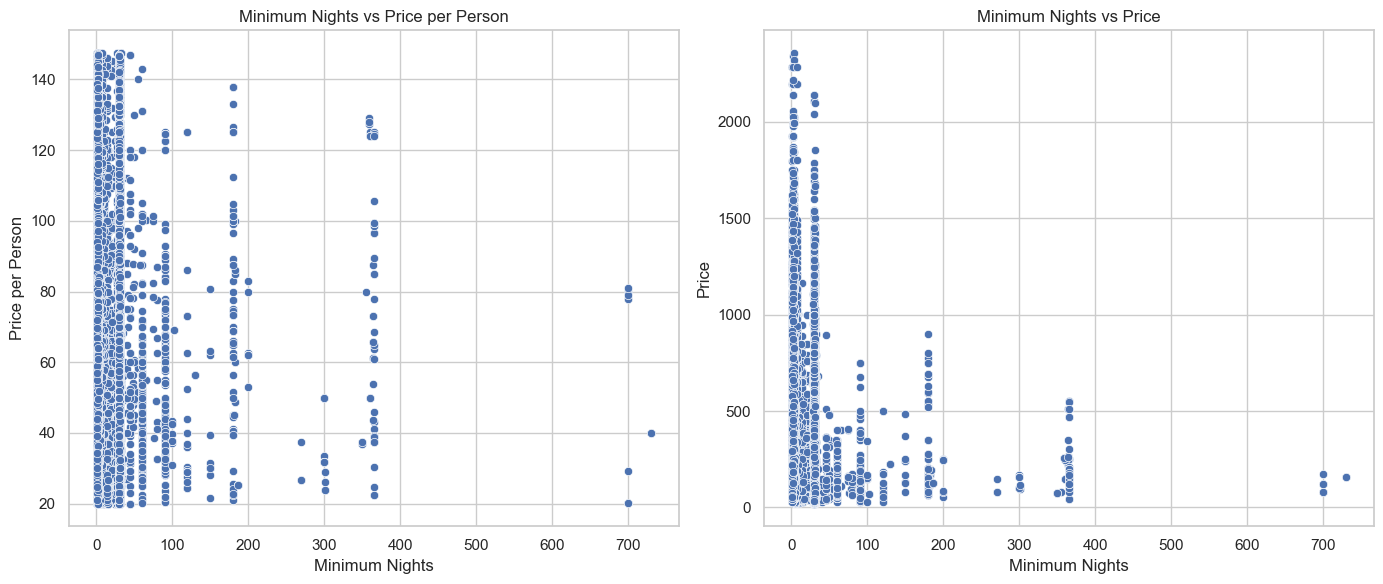

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
sns.set(style="whitegrid")

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatterplot for minimum_nights vs price_per_person
sns.scatterplot(data=final_df, x='minimum_nights', y='price_per_person', ax=axes[0])
axes[0].set_title('Minimum Nights vs Price per Person')
axes[0].set_xlabel('Minimum Nights')
axes[0].set_ylabel('Price per Person')

# Scatterplot for minimum_nights vs price
sns.scatterplot(data=final_df, x='minimum_nights', y='price', ax=axes[1])
axes[1].set_title('Minimum Nights vs Price')
axes[1].set_xlabel('Minimum Nights')
axes[1].set_ylabel('Price')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

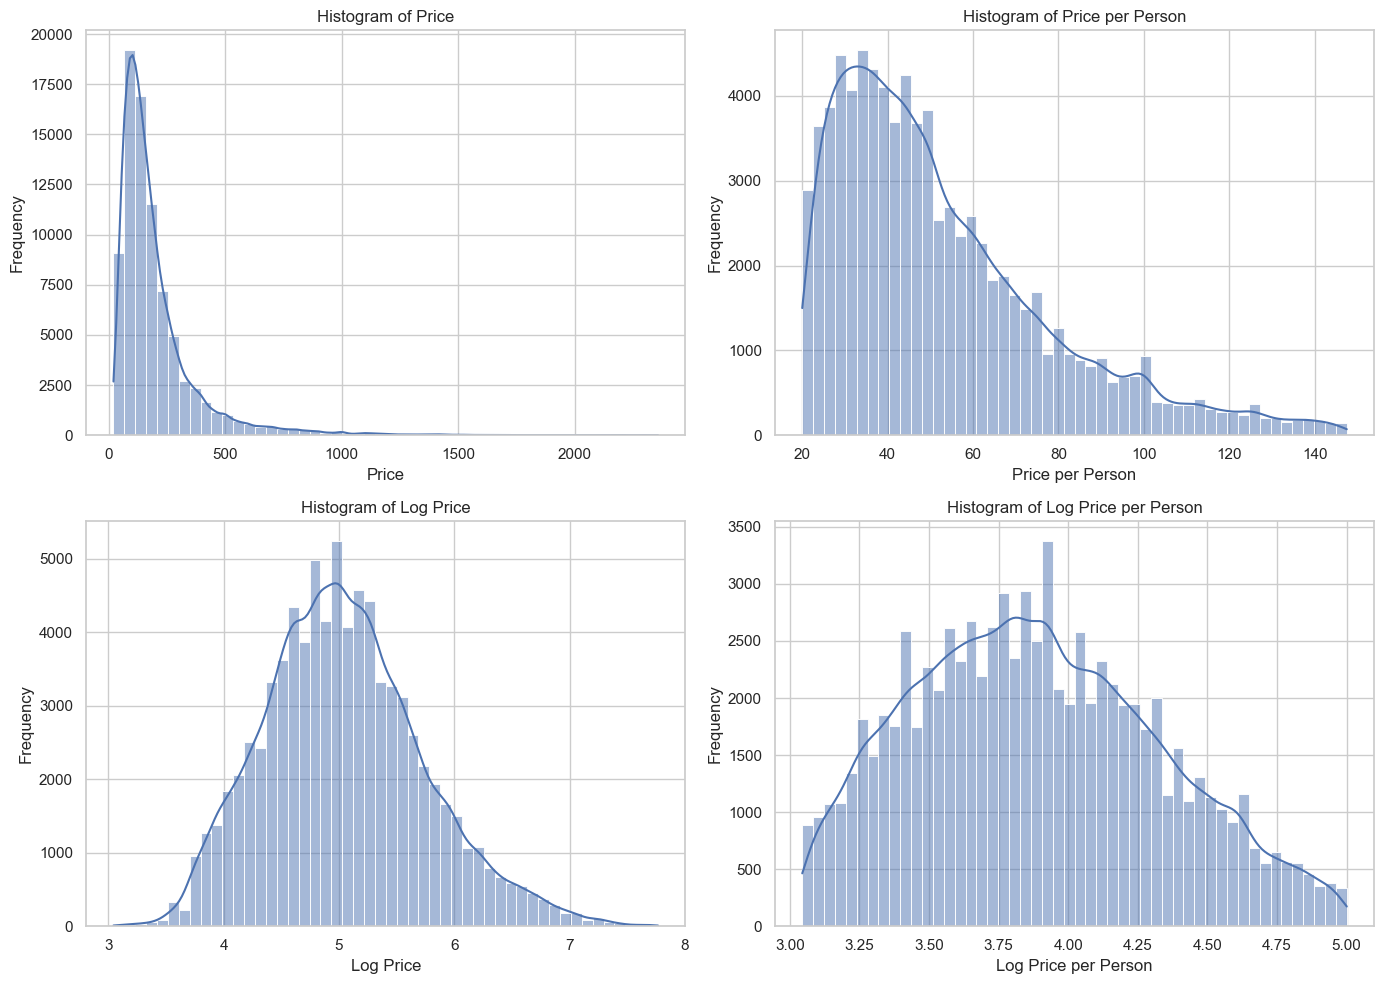

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
sns.set(style="whitegrid")

# Create a figure with four subplots (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram for price
sns.histplot(data=final_df, x='price', ax=axes[0, 0], bins=50, kde=True)
axes[0, 0].set_title('Histogram of Price')
axes[0, 0].set_xlabel('Price')
axes[0, 0].set_ylabel('Frequency')

# Histogram for price_per_person
sns.histplot(data=final_df, x='price_per_person', ax=axes[0, 1], bins=50, kde=True)
axes[0, 1].set_title('Histogram of Price per Person')
axes[0, 1].set_xlabel('Price per Person')
axes[0, 1].set_ylabel('Frequency')

# Histogram for log_price
sns.histplot(data=final_df, x='log_price', ax=axes[1, 0], bins=50, kde=True)
axes[1, 0].set_title('Histogram of Log Price')
axes[1, 0].set_xlabel('Log Price')
axes[1, 0].set_ylabel('Frequency')

# Histogram for log_price_per_person
sns.histplot(data=final_df, x='log_price_per_person', ax=axes[1, 1], bins=50, kde=True)
axes[1, 1].set_title('Histogram of Log Price per Person')
axes[1, 1].set_xlabel('Log Price per Person')
axes[1, 1].set_ylabel('Frequency')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [48]:
# paste into your notebook
import numpy as np
import scipy.stats as stats

cols = ['price', 'price_per_person', 'log_price', 'log_price_per_person']
for c in cols:
    vals = final_df[c].dropna().values
    skew = stats.skew(vals)
    kurt = stats.kurtosis(vals)   # Fisher (0 for normal)
    shapiro_p = stats.shapiro(vals[:5000])[1] if len(vals)>3 else np.nan  # sample-limited
    print(f"{c}: skew={skew:.3f}, kurtosis={kurt:.3f}, shapiro_p≈{shapiro_p:.3g}")

price: skew=3.415, kurtosis=18.110, shapiro_p≈9.78e-72
price_per_person: skew=1.205, kurtosis=1.178, shapiro_p≈8.28e-47
log_price: skew=0.420, kurtosis=0.163, shapiro_p≈1.74e-28
log_price_per_person: skew=0.275, kurtosis=-0.616, shapiro_p≈1.82e-21


### 8. Finalize & Save Modeling Dataset

In [49]:
import re

def check_sanitization(df, columns_to_check):
    """
    Checks if the specified columns in the DataFrame are suitably sanitized.
    Reports any remaining HTML tags, surrogates, or non-ASCII characters.
    """
    issues_found = False
    
    for col in columns_to_check:
        if col not in df.columns:
            print(f"Column '{col}' not found in DataFrame.")
            continue
        
        print(f"\nChecking column: '{col}'")
        
        # Check for HTML tags
        html_mask = df[col].astype(str).str.contains(r'<.*?>', regex=True)
        if html_mask.any():
            issues_found = True
            print(f"  - Found HTML tags in {html_mask.sum()} rows.")
        
        # Check for surrogates
        surrogate_mask = df[col].astype(str).str.contains(r'[\ud800-\udfff]', regex=True)
        if surrogate_mask.any():
            issues_found = True
            print(f"  - Found surrogate characters in {surrogate_mask.sum()} rows.")
        
        # Check for non-ASCII characters (optional, as per previous cleaning)
        non_ascii_mask = df[col].astype(str).str.contains(r'[^\x00-\x7F]', regex=True)
        if non_ascii_mask.any():
            issues_found = True
            print(f"  - Found non-ASCII characters in {non_ascii_mask.sum()} rows.")
        
        if not (html_mask.any() or surrogate_mask.any() or non_ascii_mask.any()):
            print("  - Column appears sanitized.")
    
    if not issues_found:
        print("\nAll specified columns are suitably sanitized.")
    else:
        print("\nIssues found in sanitization.")

# Usage: Check 'description' and 'amenities' columns
check_sanitization(final_df, ['description', 'amenities'])


Checking column: 'description'
  - Column appears sanitized.

Checking column: 'amenities'
  - Column appears sanitized.

All specified columns are suitably sanitized.


In [50]:
# Save to Parquet
output_path = os.path.join(OUTPUT_DATA_DIR, OUTPUT_FILENAME)
print(f"\nSaving to {output_path}...")
final_df.to_parquet(output_path, index=False)
print("Done.")


Saving to ../data/la/la_dataset_oct_20.parquet...
Done.


In [51]:
# Save a sample with all occurrences of 2 random listings
sample_ids = np.random.choice(final_df['id'].unique(), size=2, replace=False)
sample_df = final_df[final_df['id'].isin(sample_ids)]
sample_output_path = os.path.join(OUTPUT_DATA_DIR, f"{CITY}_sample_listings_oct_20.csv")
sample_df.to_csv(sample_output_path, index=False)
print(f"Sample listings saved to {sample_output_path}.")

Sample listings saved to ../data/la/la_sample_listings_oct_20.csv.
